<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week4_Customer_Churn_Decision_Tree_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO 371: Data Mining Applications

## Week 4: Decision Tree
### Prof. Charles Dorner, EdD (Candidate)
### College of Computing and Informatics, Drexel University

In [ ]:
# ---------- Demo 2:  BUY‑LAPTOP example  -------------------------------
import numpy as np, pandas as pd, math, matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


In [ ]:
# ❶ Create a tiny, interpretable dataset (20 customers)
np.random.seed(7)
df = pd.DataFrame({
    "age_band"   : np.random.choice(["18‑25","26‑40","41‑60"], 20,
                                    p=[0.35,0.45,0.20]),
    "income_lvl" : np.random.choice(["low","med","high"], 20,
                                    p=[0.40,0.40,0.20]),
    "owns_tablet": np.random.choice(["yes","no"], 20, p=[0.55,0.45]),
})
# rule to make target non‑trivial
df["buy"] = np.where(
        (df.age_band=="26‑40") & (df.income_lvl!="low"), "yes",
        np.where((df.owns_tablet=="no") & (df.income_lvl=="high"), "yes", "no")
)

print(df.head())

  age_band income_lvl owns_tablet  buy
0    18‑25        med         yes   no
1    26‑40       high         yes  yes
2    26‑40        low          no   no
3    26‑40        med         yes  yes
4    41‑60       high         yes   no


In [ ]:
# ❷ Compute entropy / gini–based information gain for each attribute
def entropy(v):
    counts = v.value_counts()
    probs  = counts / counts.sum()
    return -(probs*np.log2(probs)).sum()

base_H = entropy(df["buy"])
print(f"\nBase entropy = {base_H:.3f} bits")

def gain(col):
    w = 0
    for _, subset in df.groupby(col):
        w += len(subset)/len(df) * entropy(subset["buy"])
    return base_H - w

for col in ["age_band","income_lvl","owns_tablet"]:
    print(f"Gain({col:<11}) = {gain(col):.3f} bits")


Base entropy = 0.722 bits
Gain(age_band   ) = 0.276 bits
Gain(income_lvl ) = 0.144 bits
Gain(owns_tablet) = 0.008 bits



Tree accuracy (resubstitution): 1.0

Textual rules:
 |--- age_band_26‑40 <= 0.50
|   |--- class: no
|--- age_band_26‑40 >  0.50
|   |--- income_lvl_low <= 0.50
|   |   |--- class: yes
|   |--- income_lvl_low >  0.50
|   |   |--- class: no



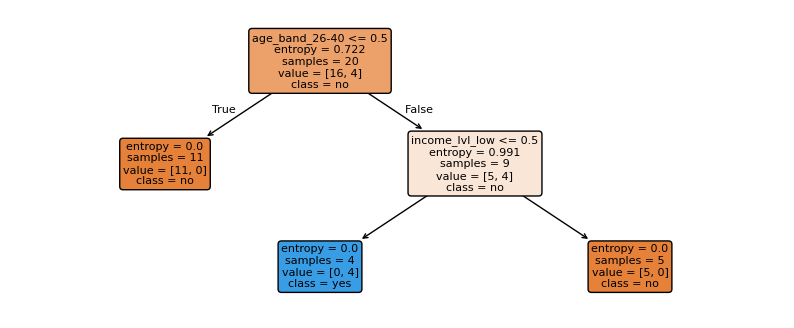

In [ ]:
# ❸ Build & visualise decision‑tree (one‑hot inside pipeline)
pipe = Pipeline([
    ("ohe",  OneHotEncoder(handle_unknown="ignore")),
    ("tree", DecisionTreeClassifier(max_depth=3, random_state=0,
                                    criterion="entropy"))
]).fit(df[["age_band","income_lvl","owns_tablet"]], df["buy"])

print("\nTree accuracy (resubstitution):",
      accuracy_score(df["buy"], pipe.predict(df[["age_band","income_lvl","owns_tablet"]])))

print("\nTextual rules:\n",
      export_text(pipe.named_steps["tree"],
                  feature_names=list(pipe.named_steps["ohe"].get_feature_names_out())))

plt.figure(figsize=(10,4))
plot_tree(pipe.named_steps["tree"],
          feature_names=pipe.named_steps["ohe"].get_feature_names_out(),
          class_names=["no","yes"], filled=True, rounded=True, fontsize=8); plt.show()